In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
data_dir = r"E:\VIT Vellore\3rd Year\5th Sem\D - AI\Project\Code\Final Dataset"

In [3]:
class_counts = {cls: len(os.listdir(os.path.join(data_dir, cls))) for cls in os.listdir(data_dir)}

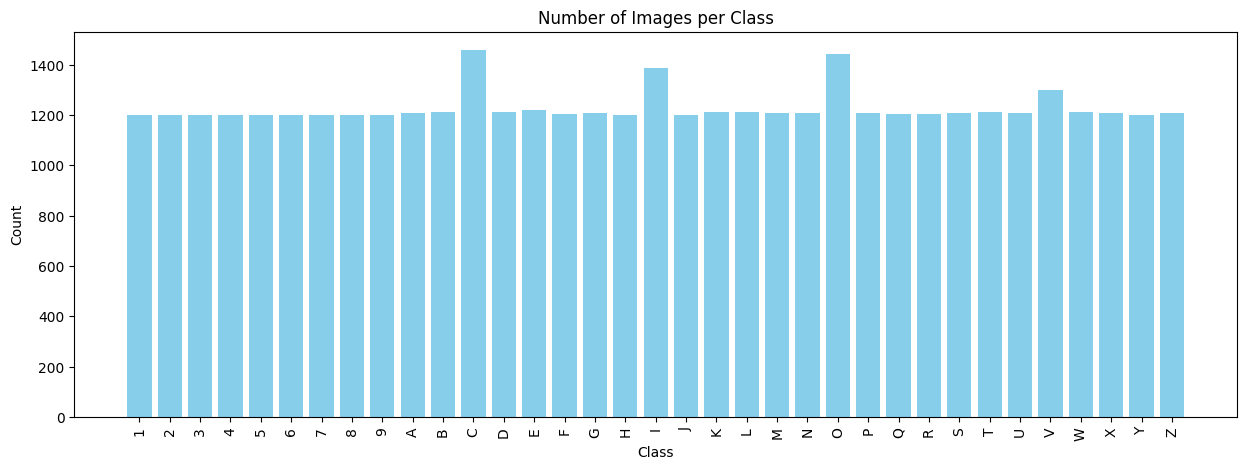

In [7]:
plt.figure(figsize=(15,5))
plt.bar(class_counts.keys(), class_counts.values(), color="skyblue")
plt.xticks(rotation=90)
plt.title("Number of Images per Class")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [8]:
print(f"Total Classes: {len(class_counts)}")
print(f"Total Images: {sum(class_counts.values())}")

Total Classes: 35
Total Images: 42954


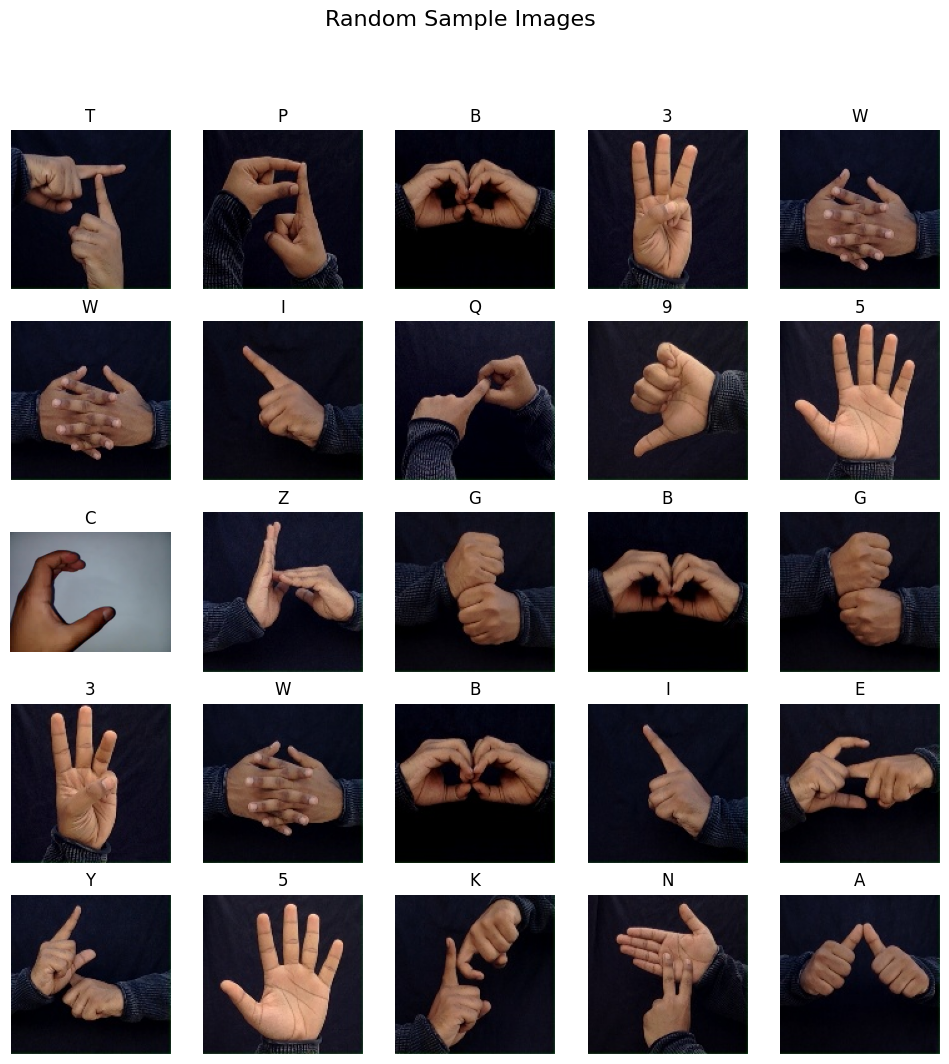

In [13]:
plt.figure(figsize=(12,12))
for i in range(25):
    cls = random.choice(list(class_counts.keys()))
    img_name = random.choice(os.listdir(os.path.join(data_dir, cls)))
    img = Image.open(os.path.join(data_dir, cls, img_name))
    plt.subplot(5,5,i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")
plt.suptitle("Random Sample Images", fontsize=16)
plt.show()

In [4]:
X, y = [], []
for cls in os.listdir(data_dir):
    for img_name in os.listdir(os.path.join(data_dir, cls))[:30]: # limit to 30 per class
        img = Image.open(os.path.join(data_dir, cls, img_name)).convert("L").resize((64,64))
        X.append(np.array(img).flatten())
        y.append(cls)


X = np.array(X)

In [16]:
X

array([[ 9, 10, 12, ..., 22, 22, 31],
       [ 9,  9, 12, ..., 22, 21, 31],
       [ 9, 10, 12, ..., 21, 21, 31],
       ...,
       [ 4,  3,  3, ..., 18, 17, 28],
       [ 4,  3,  3, ..., 17, 16, 27],
       [ 4,  3,  4, ..., 17, 16, 27]], dtype=uint8)

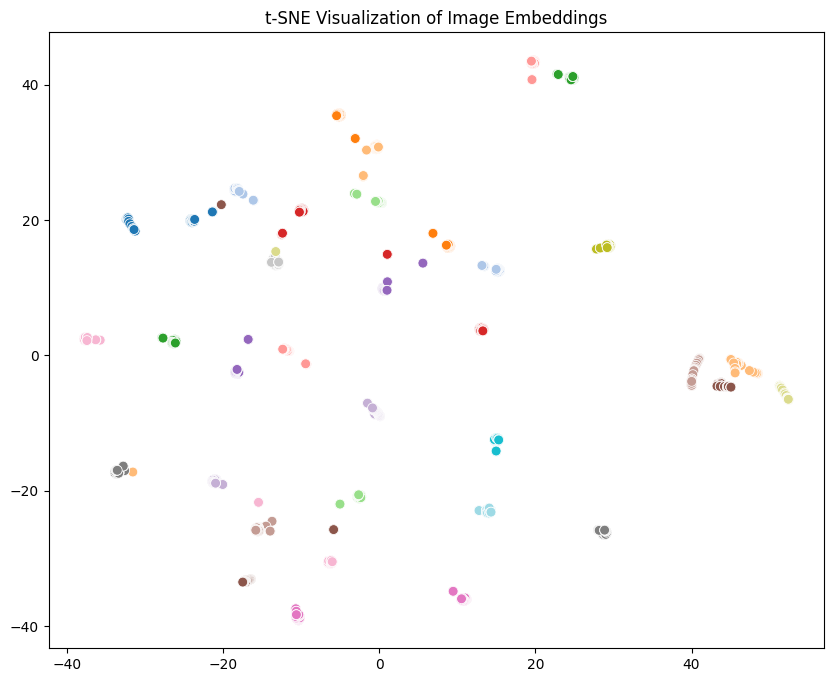

In [17]:
# PCA for dimensionality reduction
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X)


# t-SNE for 2D visualization
X_tsne = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(X_pca)


plt.figure(figsize=(10,8))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=y, palette="tab20", legend=False, s=50)
plt.title("t-SNE Visualization of Image Embeddings")
plt.show()

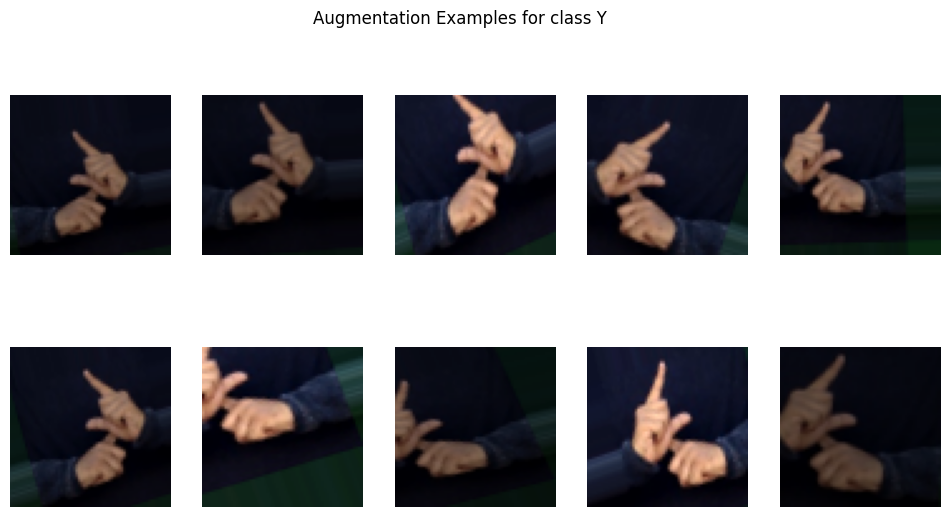

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


sample_cls = random.choice(list(class_counts.keys()))
sample_img_name = random.choice(os.listdir(os.path.join(data_dir, sample_cls)))
img = Image.open(os.path.join(data_dir, sample_cls, sample_img_name)).convert("RGB").resize((64,64))
img_array = np.expand_dims(np.array(img), 0)


aug = ImageDataGenerator(rotation_range=20,
width_shift_range=0.2,
height_shift_range=0.2,
zoom_range=0.2,
horizontal_flip=True,
brightness_range=[0.5,1.5])


plt.figure(figsize=(12,6))        
for i, batch in enumerate(aug.flow(img_array, batch_size=1)):
    plt.subplot(2,5,i+1)
    plt.imshow(batch[0].astype("uint8"))
    plt.axis("off")
    if i == 9:
        break
plt.suptitle(f"Augmentation Examples for class {sample_cls}")
plt.show()

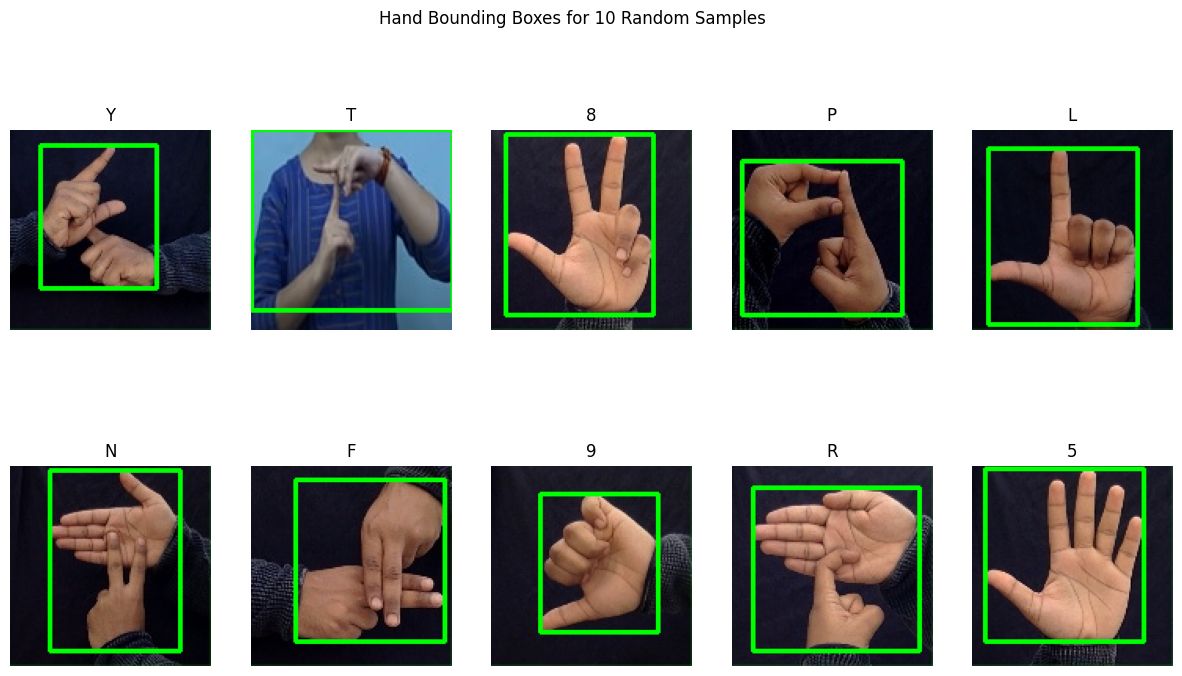

In [22]:
import cv2
import random
import matplotlib.pyplot as plt

# Function to extract hand bounding box
def get_hand_bbox(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        cnt = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(img, (x,y), (x+w, y+h), (0,255,0), 2)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Pick 10 random sample images
sample_classes = random.sample(os.listdir(data_dir), 10)  # pick 2 random classes
sample_images = []
for cls in sample_classes:
    img_files = random.sample(os.listdir(os.path.join(data_dir, cls)), 1)  # 5 from each
    sample_images.extend([os.path.join(data_dir, cls, f) for f in img_files])

plt.figure(figsize=(15,8))
for i, img_path in enumerate(sample_images):
    plt.subplot(2,5,i+1)
    plt.imshow(get_hand_bbox(img_path))
    plt.axis("off")
    plt.title(os.path.basename(os.path.dirname(img_path)))
plt.suptitle("Hand Bounding Boxes for 10 Random Samples")
plt.show()


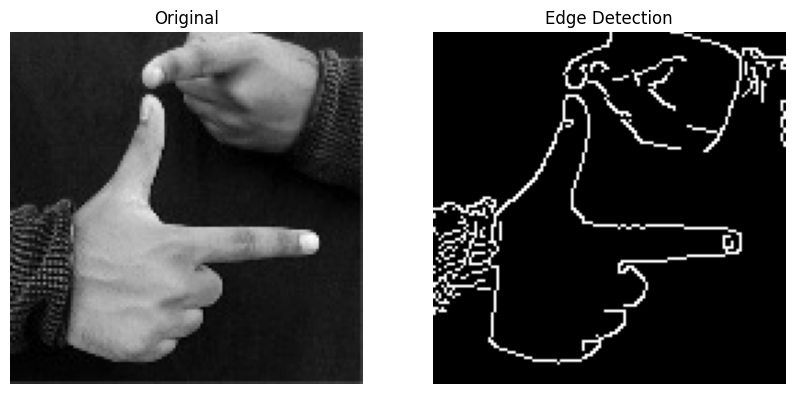

In [29]:
edge_cls = random.choice(list(class_counts.keys()))
edge_img_name = random.choice(os.listdir(os.path.join(data_dir, edge_cls)))
edge_img = cv2.imread(os.path.join(data_dir, edge_cls, edge_img_name), cv2.IMREAD_GRAYSCALE)


edges = cv2.Canny(edge_img, 100, 200)


plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(edge_img, cmap="gray")
plt.title("Original")
plt.axis("off")


plt.subplot(1,2,2)
plt.imshow(edges, cmap="gray")
plt.title("Edge Detection")
plt.axis("off")
plt.show()

In [41]:
from PIL import Image
import os
import random
from collections import Counter

# pick a random class
sample_cls = random.choice(list(class_counts.keys()))
print(f"Selected Class: {sample_cls}")

# get image paths for that class
cls_path = os.path.join(data_dir, sample_cls)
img_files = os.listdir(cls_path)

# check sizes
sizes = []
for img_name in img_files:
    try:
        with Image.open(os.path.join(cls_path, img_name)) as img:
            sizes.append(img.size)  # (width, height)
    except:
        continue

# summarize
size_counts = Counter(sizes)

print(f"\nUnique Resolutions in class '{sample_cls}':")
for size, count in size_counts.items():
    print(f"Resolution {size} -> {count} images")

print(f"\nTotal images checked: {len(sizes)}")


Selected Class: V

Unique Resolutions in class 'V':
Resolution (128, 128) -> 1209 images
Resolution (1920, 1088) -> 90 images

Total images checked: 1299
